In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import math
import numpy as np
from pyDOE import lhs
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.backends.backend_pdf
np.set_printoptions(precision=2)

In [2]:
Nf = 10000
cv = 0.6
batch_size = 100
shuffle = 10000
learning_rate = 0.001
n_layers = 10
n_units = 20
epochs = 10000

In [4]:
data = np.load('data/drained_top.npz')
z = data['z'].flatten()[:,None]
t = data['t'].flatten()[:,None]
u_anasol = np.real(data['u']).T

# Create meshgrid
Z, T = np.meshgrid(z, t)
zt_grid = np.hstack((Z.flatten()[:,None], T.flatten()[:,None]))
u_grid = u_anasol.flatten()[:,None]

# Extract initial and boundary data for training
zt_initial = np.hstack((Z[0:1,:].T, T[0:1,:].T))
u_initial = u_anasol[0:1,:].T
#zt_t1 = np.hstack((Z[1:2,:].T, T[1:2,:].T))
#u_t1 = u_anasol[1:2,:].T
zt_top = np.hstack((Z[:,0:1], T[:,0:1]))
u_top = u_anasol[:,0:1]
zt_bottom = np.hstack((Z[:,-1:], T[:,-1:]))
u_bottom = u_anasol[:,-1:]
#zt_mid = np.hstack((Z[:,50:51], T[:,50:51]))
#u_mid = u_anasol[:,50:51]

# Create training data
zt_train = np.vstack([zt_initial, zt_top, zt_bottom])
z_train = tf.convert_to_tensor(zt_train[:,0:1], dtype=tf.float32) 
t_train = tf.convert_to_tensor(zt_train[:,1:2], dtype=tf.float32) 
u_train = np.vstack([u_initial, u_top, u_bottom])
u_train = tf.convert_to_tensor(u_train, dtype=tf.float32)

# Get (z,t) bounds
zt_min = zt_grid.min(0)
zt_max = zt_grid.max(0)

# Generate collocation points and stack training data
zt_coll = zt_min + (zt_max - zt_min) * lhs(2, Nf)
zt_coll = np.vstack((zt_coll, zt_train))
z_coll = tf.convert_to_tensor(zt_coll[:,0:1], dtype=tf.float32)
t_coll = tf.convert_to_tensor(zt_coll[:,1:2], dtype=tf.float32)

zt_for_training = tf.concat([z_train, t_train], axis=1)
train_ds = tf.data.Dataset.from_tensor_slices(
    (zt_for_training, u_train)).shuffle(shuffle).batch(batch_size)

In [5]:
layers = []
for i in range(n_layers):
    if i == 0:
        layer = tf.keras.layers.Dense(n_units, activation='tanh', input_dim=2)
    else:
        layer = tf.keras.layers.Dense(n_units, activation='tanh')
    layers.append(layer)      

output_layer = tf.keras.layers.Dense(1)
layers.append(output_layer)

model = tf.keras.Sequential(layers)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
u_loss = tf.keras.metrics.Mean(name='u_loss')
f_loss = tf.keras.metrics.Mean(name='f_loss')

In [6]:
@tf.function
def train_step(zt_t, u, z_coll, t_coll):
    with tf.GradientTape() as tape0:
        with tf.GradientTape() as tape1:
            tape1.watch(z_coll)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(z_coll)
                tape2.watch(t_coll)
                u_pred = model(zt_t, training=True)
                u_coll = model(tf.concat([z_coll, t_coll], axis=1), training=True)
            dudt = tape2.gradient(u_coll, t_coll)
            dudz = tape2.gradient(u_coll, z_coll)
        d2udz2 = tape1.gradient(dudz, z_coll)
        f_coll = dudt - cv * d2udz2        
        mse_u = tf.reduce_mean(tf.square(u - u_pred))
        mse_f = tf.reduce_mean(tf.square(f_coll))
        mse = mse_u + mse_f        
    grads = tape0.gradient(mse, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(mse)
    u_loss(mse_u)
    f_loss(mse_f)    
    return mse

In [7]:
losses, u_losses, f_losses = [], [], []
for epoch in range(epochs):
    train_loss.reset_states()
    u_loss.reset_states()
    f_loss.reset_states()   
    for zt_t, u in train_ds:
        train_step(zt_t, u, z_coll, t_coll)
    template = 'Loss: {}'
    print(template.format(train_loss.result()))
    losses.append(train_loss.result())
    u_losses.append(u_loss.result())
    f_losses.append(f_loss.result())
print('Training completed!')

s: 0.0003376788226887584
Loss: 0.00018830916087608784
Loss: 0.00022514828015118837
Loss: 0.000160263865836896
Loss: 0.0002883067645598203
Loss: 0.00012009763304376975
Loss: 0.00024081084120552987
Loss: 0.00012632911966647953
Loss: 0.0001353714324068278
Loss: 0.000145586600410752
Loss: 7.86514938226901e-05
Loss: 9.212480654241517e-05
Loss: 0.00018843612633645535
Loss: 0.0003050226951017976
Loss: 0.00020008363935630769
Loss: 0.00010164210107177496
Loss: 0.00020803067309316248
Loss: 9.020395373227075e-05
Loss: 0.00015331026224885136
Loss: 0.0001395442377543077
Loss: 4.842228372581303e-05
Loss: 5.4489559261128306e-05
Loss: 0.0001825350773287937
Loss: 0.0002966938482131809
Loss: 0.00014588533667847514
Loss: 0.0002817491185851395
Loss: 0.00016310943465214223
Loss: 0.0004237807879690081
Loss: 0.0003076396824326366
Loss: 0.00041014826274476945
Loss: 0.0002612815296743065
Loss: 0.0004925064276903868
Loss: 0.0004264717863406986
Loss: 0.00041039680945686996
Loss: 0.0002275477017974481
Loss: 0.000

In [8]:
model.save('saved_model/model_drained_top')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_drained_top\assets


In [10]:
z_test = tf.convert_to_tensor(zt_grid[:,0:1], dtype=tf.float32)
t_test = tf.convert_to_tensor(zt_grid[:,1:2], dtype=tf.float32)

with tf.GradientTape() as tape3:
  tape3.watch(z_test)
  with tf.GradientTape(persistent=True) as tape4:
      tape4.watch(z_test)
      tape4.watch(t_test)
      u_test = model(tf.concat([z_test, t_test], axis=1))
  dudz = tape4.gradient(u_test, z_test)
  dudt = tape4.gradient(u_test, t_test)
d2udz2 = tape3.gradient(dudz, z_test)
f = dudt - cv * d2udz2

Error u: 7.329299e-03


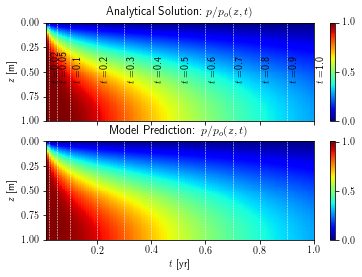

In [68]:
error_u = np.linalg.norm(u_grid - u_test, 2) / np.linalg.norm(u_grid, 2)
print('Error u: {:e}'.format(error_u))

u_test_grid = griddata(zt_grid, u_test.numpy().flatten(), (Z, T), method='cubic')
Error = np.abs(u_anasol - u_test_grid)

plt.rc('text', usetex=True)

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4), sharex=True)
anasol = ax1.imshow(u_anasol.T, interpolation='nearest', cmap='jet',
          extent=[t.min(), t.max(), z.max(), z.min()],
          origin='lower', aspect='auto')
fig1.colorbar(anasol, ax=ax1)
#ax1.plot(zt_train[:,1], zt_train[:,0], 'kx')
line = np.linspace(z.min(), z.max(), 2).reshape(-1, 1)

t_idx = [1, 4, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
for i in t_idx:
    ax1.plot(t[i]*np.ones((2,1)), line, 'w--', linewidth=0.5)
    if i == 69:
        ax1.text(t[i]+0.01, 0.6, '$t=$' + str(0.7), rotation=90)
    else:
        ax1.text(t[i]+0.01, 0.6, '$t=$' + str(t[i][0]), rotation=90)
ax1.set_ylabel('$z$ [m]')
ax1.set_title(r'Analytical Solution: $p/p_o(z,t)$')


pred = ax2.imshow(u_test_grid.T, interpolation='nearest', cmap='jet',
          extent=[t.min(), t.max(), z.max(), z.min()],
          origin='lower', aspect='auto')
fig1.colorbar(pred, ax=ax2)
for i in t_idx:
    ax2.plot(t[i]*np.ones((2,1)), line, 'w--', linewidth=0.5)
ax2.set_xlabel('$t$ [yr]')
ax2.set_ylabel('$z$ [m]')
ax2.set_title(r'Model Prediction: $p/p_o(z,t)$')

plt.savefig('plots/color_plot_drained_top.pdf')

Text(0, 0.5, '$MSE$')

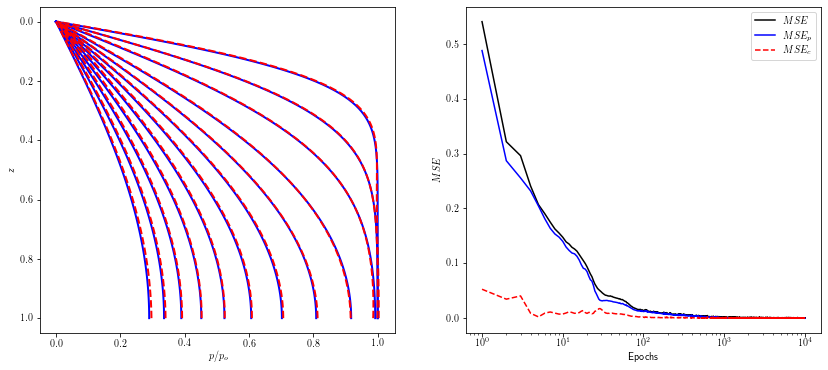

In [39]:
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))

for i in t_idx:
    ax3.plot(u_anasol[i:i+1,:].T, -z+1, 'b-', linewidth=2) #, label='Analytical t={:.2f}'.format(t[i][0]))
    ax3.plot(u_test_grid[i:i+1,:].T, -z+1, 'r--', linewidth=2) #, label='Prediction t={:.2f}'.format(t[i][0]))
#ax3.legend(frameon=False, loc='best')
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xlabel('$p/p_o$')
ax3.set_ylabel('$z$')

ax4.semilogx(range(1, epochs+1), losses, 'k-', label='$MSE$')
ax4.semilogx(range(1, epochs+1), u_losses, 'b-',  label='$MSE_p$')
ax4.semilogx(range(1, epochs+1), f_losses, 'r--', label='$MSE_c$')
ax4.legend(loc='best')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('$MSE$')